# Supplementary: AdultRR eggRR calculations

Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 15 Dec 22

In [ ]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import statsmodels.api as sm
import json
import time
import os

### 1. Set up model
Parameters:

In [40]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI = 0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT = 0    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c = 0.5      # mating competitiveness of released wolbachia males
cv = 0.128   #coverage of adulticide
e = 1.2      # relative mortality of wolbachia adults compared to wild adults
RR = 1       # release ratio of wolbachia eggs to wild type eggs
RRsupp = 1      # release ratio of wolbachia eggs to wild type eggs for suppression techniques
RR = 1

Initial conditions:
(equilibrium values previously defined in Supp)

In [41]:
O0 = 15947.608023052446
OW0 = 0
rOW0 = 0
OS0 = 0
L0 = 40271.71074193975
LW0 = 0
rLW0 = 0
LS0 = 0
P0 = 32.67541200187585
PW0 = 0
rPW0 = 0
PS0 = 0
M0 = 228.72754035145144
rMW0 = 0
MW0 = 0
MS0 = 0
F0 = 228.72754035145144
rFW0 = 0
FW0 = 0

Wolbachia release function:

In [42]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=1, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return O0
    else:
        return 0

Suppression functions:

In [43]:
# IIT

def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [44]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [45]:
# Environmental management

start_em = 193
stop_em = 200
em_eff = 1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [46]:
# Larvicides (e.g. guppies)

start_lv = 193
stop_lv = 200
lv_eff = 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [47]:
# Adulticide

h = start_wol

def ad(t):    
    ad_eff = 0 #4.9 #0.455
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return ad_eff

# NEW efficacy (fixed brackets)
# 4.9 = 90%
    
# efficacy
# 3 = ~90% | 1.9 = ~80% | 1.38 = ~70% | 1.03 = ~60% | 0.77 = ~50%
# 0.56 = ~40% | 0.39 = ~30% | 0.24 = ~20% | 0.11 = ~10%

Model:

In [48]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, rMW, MW, MS, F, rFW, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW+rFW
    allmales = 1+M+MW+(MS*c)+rMW
    
    F_nothing = F + rFW*FW*MT 
    M_nothing = M + rMW*MW*fCI 
    
    F_wol = rFW*FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+rMW+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    drMWdt =  .5*alphaP*rPW - muM*e*rMW - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*PW - muM*e*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp - muM*e*MS # + .5*alphaP*PS remove for 1gSLT
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    drFWdt =  .5*alphaP*rPW - muF*e*rFW - ad(t)*F*cv
    dFWdt = .5*alphaP*PW - muF*e*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, drMWdt, dMWdt, dMSdt, dFdt, drFWdt, dFWdt

Model prerequisites and run:

In [49]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, rMW0, MW0, MS0, F0, rFW0, FW0 # initial condition vector

ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, rMW, MW, MS, F, rFW, FW = ret.T

Visual check all suppression functions are switched off: (should only see Wolbachia release)

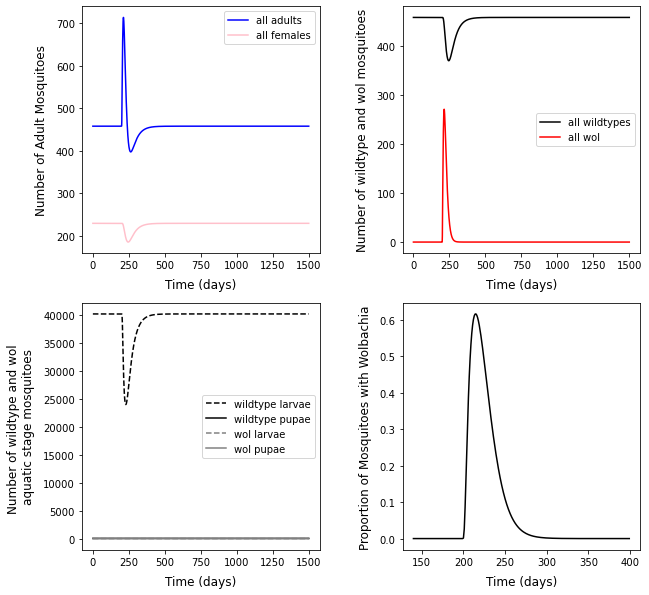

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW+rFW+rMW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW+rFW+rMW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (rMW[140:400]+rFW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia", fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

#plt.savefig('wolAedesDemo-KT', dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', format=None, transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

In [24]:
O_base = O
L_base = L
P_base = P
M_base = M
F_base = F

### 2. Calculate adultRR to eggRR pairs
Calculates egg release ratio values for each adult release ratio (as eggs as released in the model but adult release ratios are reported)

In [173]:
adultRR_eggRR_df = pd.DataFrame( #capture results here
    {'adultRR': np.linspace(0.0025, 0.5, 200),
     'eggRR': 'NaN'})

In [180]:
start_time = time.time()



loop_n = 0
duration = 0
RR = 0
f = 0.0005 #start coarse then slow down for refinement in regions of interest
x = 0 #decides level of refinement in regions of interest


for j in np.linspace(0.0025, 0.5, 200)[:]: #np.linspace(0.01, 1, 100)[:]: #np.linspace(0.025, 3, 120)[:]: #np.linspace(0.05, 5, 100)[:]: # explore adultRR parameter space
    
    loop_start_time = time.time()
    loop_n = loop_n+1
        
    print('   LOOP',loop_n,": adultRR",j,)
        
        
    while RR < 1000: # find matching eggRR to adultRR
        RR = RR + f 
               
        # Wolbachia release function
        def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
            for i in range(0,releasenumber,1):
                if round(t) == start_wol + (frequency*i):
                    return O0
            else:
                return 0
            
        # run model
        t = np.linspace(0, 1500, 1501) # grid of time points (in days)
        y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, rMW0, MW0, MS0, F0, rFW0, FW0 # initial condition vector
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1) #,full_output=False)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, rMW, MW, MS, F, rFW, FW = ret.T
    
        new_mosq = (max(rMW[start_wol:])+max(rFW[start_wol:]))
        total = M_base[start_wol-1]+F_base[start_wol-1]
        goal = total*j # calc using adultRR
                        
        print(goal-2.5,'<',new_mosq,'<',goal+2.5,'         f=',f)
            
            
        # calc if RR is high enough or overshot
        if goal-2.5 < new_mosq < goal+2.5:
            adultRR_eggRR_df.loc[(adultRR_eggRR_df['adultRR'] == j), ['eggRR']] = RR               
            f = 0.0005
            break
        elif goal+2.5 < new_mosq:
            print("      couldn't find RR")
            f = 0.0005
            break

    
    current_time = time.time()
    duration = round((current_time - loop_start_time)/60,2)
    if 1.25 < duration:
        x = x+1
        print('x=',x)
    print('         time - ',duration,'minutes')
        
end_time = time.time()
elapsed_time = end_time - start_time
print('start_wol ',start_wol,'FINISHED',":",round(elapsed_time/60,2),'minutes')

   LOOP 1 : adultRR 0.0025
-1.3563576839132396 < 2.0691068578183924 < 3.64364231608676          f= 0.0005
         time -  0.0 minutes
   LOOP 2 : adultRR 0.005
-0.21271536782647926 < 3.2710727559386332 < 4.78728463217352          f= 0.0005
         time -  0.0 minutes
   LOOP 3 : adultRR 0.0075
0.9309269482602809 < 4.227952213854044 < 5.93092694826028          f= 0.0005
         time -  0.0 minutes
   LOOP 4 : adultRR 0.01
2.0745692643470415 < 5.049038494461326 < 7.0745692643470415          f= 0.0005
         time -  0.0 minutes
   LOOP 5 : adultRR 0.0125
3.2182115804338025 < 5.780204606783619 < 8.218211580433803          f= 0.0005
         time -  0.0 minutes
   LOOP 6 : adultRR 0.015000000000000001
4.361853896520563 < 6.446034843937745 < 9.361853896520563          f= 0.0005
         time -  0.0 minutes
   LOOP 7 : adultRR 0.017499999999999998
5.505496212607321 < 7.061562214049279 < 10.505496212607321          f= 0.0005
         time -  0.0 minutes
   LOOP 8 : adultRR 0.02
6.64913852

28.378342534342533 < 28.549689470057597 < 33.378342534342536          f= 0.0005
         time -  0.01 minutes
   LOOP 28 : adultRR 0.07
29.52198485042929 < 28.72288077465692 < 34.52198485042929          f= 0.0005
29.52198485042929 < 28.895097462432407 < 34.52198485042929          f= 0.0005
29.52198485042929 < 29.06635575816582 < 34.52198485042929          f= 0.0005
29.52198485042929 < 29.2366716128872 < 34.52198485042929          f= 0.0005
29.52198485042929 < 29.406060304638366 < 34.52198485042929          f= 0.0005
29.52198485042929 < 29.574536879912365 < 34.52198485042929          f= 0.0005
         time -  0.01 minutes
   LOOP 29 : adultRR 0.07250000000000001
30.665627166516053 < 29.74211587654798 < 35.66562716651605          f= 0.0005
30.665627166516053 < 29.90881151319603 < 35.66562716651605          f= 0.0005
30.665627166516053 < 30.074637402166662 < 35.66562716651605          f= 0.0005
30.665627166516053 < 30.23960765137529 < 35.66562716651605          f= 0.0005
30.6656271665160

42.10205032738366 < 42.173811385080214 < 47.10205032738366          f= 0.0005
         time -  0.02 minutes
   LOOP 40 : adultRR 0.1
43.24569264347042 < 42.29362525605509 < 48.24569264347042          f= 0.0005
43.24569264347042 < 42.41311480556376 < 48.24569264347042          f= 0.0005
43.24569264347042 < 42.53228315769082 < 48.24569264347042          f= 0.0005
43.24569264347042 < 42.651132756464094 < 48.24569264347042          f= 0.0005
43.24569264347042 < 42.76966589650219 < 48.24569264347042          f= 0.0005
43.24569264347042 < 42.88788523454607 < 48.24569264347042          f= 0.0005
43.24569264347042 < 43.00579321734162 < 48.24569264347042          f= 0.0005
43.24569264347042 < 43.12339262637291 < 48.24569264347042          f= 0.0005
43.24569264347042 < 43.240685582741236 < 48.24569264347042          f= 0.0005
43.24569264347042 < 43.35767461506616 < 48.24569264347042          f= 0.0005
         time -  0.02 minutes
   LOOP 41 : adultRR 0.10250000000000001
44.389334959557175 < 43.

53.538473488251256 < 52.77603004333321 < 58.538473488251256          f= 0.0005
53.538473488251256 < 52.872652575402306 < 58.538473488251256          f= 0.0005
53.538473488251256 < 52.969106260065615 < 58.538473488251256          f= 0.0005
53.538473488251256 < 53.06538972457103 < 58.538473488251256          f= 0.0005
53.538473488251256 < 53.16150503216327 < 58.538473488251256          f= 0.0005
53.538473488251256 < 53.25745251679401 < 58.538473488251256          f= 0.0005
53.538473488251256 < 53.353233712124094 < 58.538473488251256          f= 0.0005
53.538473488251256 < 53.44884892950844 < 58.538473488251256          f= 0.0005
53.538473488251256 < 53.54429982961288 < 58.538473488251256          f= 0.0005
         time -  0.02 minutes
   LOOP 50 : adultRR 0.125
54.68211580433802 < 53.639586151731066 < 59.68211580433802          f= 0.0005
54.68211580433802 < 53.73470924271426 < 59.68211580433802          f= 0.0005
54.68211580433802 < 53.82966954968449 < 59.68211580433802          f= 0.00

62.68761201694535 < 61.71593288614629 < 67.68761201694535          f= 0.0005
62.68761201694535 < 61.798995286684544 < 67.68761201694535          f= 0.0005
62.68761201694535 < 61.88194977851669 < 67.68761201694535          f= 0.0005
62.68761201694535 < 61.9647961779829 < 67.68761201694535          f= 0.0005
62.68761201694535 < 62.04753509589972 < 67.68761201694535          f= 0.0005
62.68761201694535 < 62.13016810579469 < 67.68761201694535          f= 0.0005
62.68761201694535 < 62.212694746596014 < 67.68761201694535          f= 0.0005
62.68761201694535 < 62.29511325518194 < 67.68761201694535          f= 0.0005
62.68761201694535 < 62.377428444924725 < 67.68761201694535          f= 0.0005
62.68761201694535 < 62.4596371161488 < 67.68761201694535          f= 0.0005
62.68761201694535 < 62.5417414286006 < 67.68761201694535          f= 0.0005
62.68761201694535 < 62.62373965122828 < 67.68761201694535          f= 0.0005
62.68761201694535 < 62.705636006997636 < 67.68761201694535          f= 0.000

70.69310822955266 < 69.693608472705 < 75.69310822955266          f= 0.0005
70.69310822955266 < 69.76742467617866 < 75.69310822955266          f= 0.0005
70.69310822955266 < 69.84116637378466 < 75.69310822955266          f= 0.0005
70.69310822955266 < 69.91483090980347 < 75.69310822955266          f= 0.0005
70.69310822955266 < 69.98842049877705 < 75.69310822955266          f= 0.0005
70.69310822955266 < 70.0619351587177 < 75.69310822955266          f= 0.0005
70.69310822955266 < 70.1353734137974 < 75.69310822955266          f= 0.0005
70.69310822955266 < 70.20873791891829 < 75.69310822955266          f= 0.0005
70.69310822955266 < 70.28202800620885 < 75.69310822955266          f= 0.0005
70.69310822955266 < 70.35524310518683 < 75.69310822955266          f= 0.0005
70.69310822955266 < 70.4283842801252 < 75.69310822955266          f= 0.0005
70.69310822955266 < 70.50145186216467 < 75.69310822955266          f= 0.0005
70.69310822955266 < 70.57444588126063 < 75.69310822955266          f= 0.0005
70.6

77.55496212607324 < 76.86735974924326 < 82.55496212607324          f= 0.0005
77.55496212607324 < 76.93445845302905 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.00150126226677 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.06848674529199 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.13541597382256 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.20228766359504 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.26910400388401 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.33586173834107 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.4025655784718 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.46921309280152 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.53580420749432 < 82.55496212607324          f= 0.0005
77.55496212607324 < 77.60233974861335 < 82.55496212607324          f= 0.0005
         time -  0.03 minutes
   LOOP 71 : adultRR 0.17750000000000002
78.698

84.41681602259379 < 83.56400077414617 < 89.41681602259379          f= 0.0005
84.41681602259379 < 83.62584697712316 < 89.41681602259379          f= 0.0005
84.41681602259379 < 83.68764738254649 < 89.41681602259379          f= 0.0005
84.41681602259379 < 83.74940377500994 < 89.41681602259379          f= 0.0005
84.41681602259379 < 83.81111684805674 < 89.41681602259379          f= 0.0005
84.41681602259379 < 83.87278286574022 < 89.41681602259379          f= 0.0005
84.41681602259379 < 83.93440588620807 < 89.41681602259379          f= 0.0005
84.41681602259379 < 83.99598552805482 < 89.41681602259379          f= 0.0005
84.41681602259379 < 84.05752053711326 < 89.41681602259379          f= 0.0005
84.41681602259379 < 84.11901083301636 < 89.41681602259379          f= 0.0005
84.41681602259379 < 84.18045852255462 < 89.41681602259379          f= 0.0005
84.41681602259379 < 84.24186095569254 < 89.41681602259379          f= 0.0005
84.41681602259379 < 84.30322070012902 < 89.41681602259379          f= 0.0005

90.1350276030276 < 89.83040156384412 < 95.1350276030276          f= 0.0005
90.1350276030276 < 89.88802703407347 < 95.1350276030276          f= 0.0005
90.1350276030276 < 89.94561291052621 < 95.1350276030276          f= 0.0005
90.1350276030276 < 90.00316527341273 < 95.1350276030276          f= 0.0005
90.1350276030276 < 90.06067969530183 < 95.1350276030276          f= 0.0005
90.1350276030276 < 90.1181592840885 < 95.1350276030276          f= 0.0005
90.1350276030276 < 90.17560213385137 < 95.1350276030276          f= 0.0005
         time -  0.04 minutes
   LOOP 82 : adultRR 0.20500000000000002
91.27866991911435 < 90.23300979441795 < 96.27866991911435          f= 0.0005
91.27866991911435 < 90.29038154901366 < 96.27866991911435          f= 0.0005
91.27866991911435 < 90.34771785917276 < 96.27866991911435          f= 0.0005
91.27866991911435 < 90.40501691356849 < 96.27866991911435          f= 0.0005
91.27866991911435 < 90.46228248102321 < 96.27866991911435          f= 0.0005
91.27866991911435 < 

95.85323918346138 < 95.69526844552172 < 100.85323918346138          f= 0.0005
95.85323918346138 < 95.74943123780704 < 100.85323918346138          f= 0.0005
95.85323918346138 < 95.80356351023924 < 100.85323918346138          f= 0.0005
95.85323918346138 < 95.85766598567571 < 100.85323918346138          f= 0.0005
         time -  0.04 minutes
   LOOP 87 : adultRR 0.2175
96.99688149954815 < 95.91173856469705 < 101.99688149954815          f= 0.0005
96.99688149954815 < 95.9657818350561 < 101.99688149954815          f= 0.0005
96.99688149954815 < 96.01979342423732 < 101.99688149954815          f= 0.0005
96.99688149954815 < 96.07377704258057 < 101.99688149954815          f= 0.0005
96.99688149954815 < 96.12773085730166 < 101.99688149954815          f= 0.0005
96.99688149954815 < 96.18165500150594 < 101.99688149954815          f= 0.0005
96.99688149954815 < 96.23554860334852 < 101.99688149954815          f= 0.0005
96.99688149954815 < 96.2894127257766 < 101.99688149954815          f= 0.0005
96.99688

101.5714507638952 < 101.07320204955042 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.1245371533125 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.17584651807562 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.2271304527701 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.27838900555875 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.32962291161745 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.38083007025517 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.43201262416713 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.48316966405552 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.53430112970686 < 106.5714507638952          f= 0.0005
101.5714507638952 < 101.58540684389843 < 106.5714507638952          f= 0.0005
         time -  0.04 minutes
   LOOP 92 : adultRR 0.23
102.71509307998195 < 101.63649002577063 < 107.71509307998195          f= 0.0005
102.7150

106.14602002824225 < 106.08598749925535 < 111.14602002824225          f= 0.0005
106.14602002824225 < 106.13494090065426 < 111.14602002824225          f= 0.0005
106.14602002824225 < 106.1838722966654 < 111.14602002824225          f= 0.0005
         time -  0.04 minutes
   LOOP 96 : adultRR 0.24000000000000002
107.289662344329 < 106.23278160871423 < 112.289662344329          f= 0.0005
107.289662344329 < 106.28166728634638 < 112.289662344329          f= 0.0005
107.289662344329 < 106.3305331846941 < 112.289662344329          f= 0.0005
107.289662344329 < 106.37937480270176 < 112.289662344329          f= 0.0005
107.289662344329 < 106.42819579971511 < 112.289662344329          f= 0.0005
107.289662344329 < 106.47699525156361 < 112.289662344329          f= 0.0005
107.289662344329 < 106.52577156066671 < 112.289662344329          f= 0.0005
107.289662344329 < 106.57452715787164 < 112.289662344329          f= 0.0005
107.289662344329 < 106.62325972655958 < 112.289662344329          f= 0.0005
107.289

111.86423160867604 < 110.87617690777815 < 116.86423160867604          f= 0.0005
111.86423160867604 < 110.92305188610658 < 116.86423160867604          f= 0.0005
111.86423160867604 < 110.96990665178915 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.01674368705137 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.06355985510807 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.11035717081691 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.1571351757141 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.20389440389208 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.25063243148051 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.29735252642944 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.3440526047822 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.39073399680889 < 116.86423160867604          f= 0.0005
111.86423160867604 < 111.43739611407361 < 

116.43880087302308 < 115.56109334913056 < 121.43880087302308          f= 0.0005
116.43880087302308 < 115.6060992891624 < 121.43880087302308          f= 0.0005
116.43880087302308 < 115.65108760134065 < 121.43880087302308          f= 0.0005
116.43880087302308 < 115.69605933413142 < 121.43880087302308          f= 0.0005
116.43880087302308 < 115.74101387654105 < 121.43880087302308          f= 0.0005
116.43880087302308 < 115.78595032014324 < 121.43880087302308          f= 0.0005
116.43880087302308 < 115.83087044556699 < 121.43880087302308          f= 0.0005
116.43880087302308 < 115.87577330069075 < 121.43880087302308          f= 0.0005
116.43880087302308 < 115.92065944879822 < 121.43880087302308          f= 0.0005
116.43880087302308 < 115.96552840332129 < 121.43880087302308          f= 0.0005
116.43880087302308 < 116.01037922866493 < 121.43880087302308          f= 0.0005
116.43880087302308 < 116.05521423993194 < 121.43880087302308          f= 0.0005
116.43880087302308 < 116.10003290231839 <

121.01337013737013 < 120.06618554855609 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.10952881822946 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.15285740276123 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.19617014838843 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.23946978918397 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.28275270733923 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.3260190022838 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.36927048645872 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.41250685760365 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.45572927368862 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.49893459523993 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.54212670575846 < 126.01337013737013          f= 0.0005
121.01337013737013 < 120.58530255011162 <

124.44429708563041 < 124.41069478060852 < 129.4442970856304          f= 0.0005
124.44429708563041 < 124.4525498878074 < 129.4442970856304          f= 0.0005
         time -  0.05 minutes
   LOOP 112 : adultRR 0.28
125.58793940171716 < 124.49438928932761 < 130.58793940171716          f= 0.0005
125.58793940171716 < 124.53621590636531 < 130.58793940171716          f= 0.0005
125.58793940171716 < 124.5780282796057 < 130.58793940171716          f= 0.0005
125.58793940171716 < 124.61982639621087 < 130.58793940171716          f= 0.0005
125.58793940171716 < 124.66161122245317 < 130.58793940171716          f= 0.0005
125.58793940171716 < 124.70338126107683 < 130.58793940171716          f= 0.0005
125.58793940171716 < 124.7451384058233 < 130.58793940171716          f= 0.0005
125.58793940171716 < 124.78688257318305 < 130.58793940171716          f= 0.0005
125.58793940171716 < 124.82861152795454 < 130.58793940171716          f= 0.0005
125.58793940171716 < 124.87032742458734 < 130.58793940171716        

129.01886634997746 < 128.5701435019223 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.61066536686513 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.6511708943822 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.6916652371344 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.7321472218092 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.77261725237813 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.81307504632142 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.85351836889217 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.89395111777722 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.93437080752955 < 134.01886634997746          f= 0.0005
129.01886634997746 < 128.97477804496995 < 134.01886634997746          f= 0.0005
129.01886634997746 < 129.01517290846917 < 134.01886634997746          f= 0.0005
129.01886634997746 < 129.0555543635065 < 134

133.59343561432448 < 132.64032634702173 < 138.59343561432448          f= 0.0005
133.59343561432448 < 132.67962092154212 < 138.59343561432448          f= 0.0005
133.59343561432448 < 132.71890520067328 < 138.59343561432448          f= 0.0005
133.59343561432448 < 132.75817605700834 < 138.59343561432448          f= 0.0005
133.59343561432448 < 132.7974358766382 < 138.59343561432448          f= 0.0005
133.59343561432448 < 132.836684625817 < 138.59343561432448          f= 0.0005
133.59343561432448 < 132.87592305152629 < 138.59343561432448          f= 0.0005
133.59343561432448 < 132.9151479022323 < 138.59343561432448          f= 0.0005
133.59343561432448 < 132.95436198327187 < 138.59343561432448          f= 0.0005
133.59343561432448 < 132.99356488902268 < 138.59343561432448          f= 0.0005
133.59343561432448 < 133.0327554041751 < 138.59343561432448          f= 0.0005
133.59343561432448 < 133.0719358726398 < 138.59343561432448          f= 0.0005
133.59343561432448 < 133.1111054432373 < 138.5

137.02436256258477 < 136.62911475339064 < 142.02436256258477          f= 0.0005
137.02436256258477 < 136.66727901844823 < 142.02436256258477          f= 0.0005
137.02436256258477 < 136.70543081790225 < 142.02436256258477          f= 0.0005
137.02436256258477 < 136.7435730550598 < 142.02436256258477          f= 0.0005
137.02436256258477 < 136.78170524780697 < 142.02436256258477          f= 0.0005
137.02436256258477 < 136.81982652229755 < 142.02436256258477          f= 0.0005
137.02436256258477 < 136.85793795257612 < 142.02436256258477          f= 0.0005
137.02436256258477 < 136.89603748115871 < 142.02436256258477          f= 0.0005
137.02436256258477 < 136.9341271947144 < 142.02436256258477          f= 0.0005
137.02436256258477 < 136.97220684262393 < 142.02436256258477          f= 0.0005
137.02436256258477 < 137.0102751339725 < 142.02436256258477          f= 0.0005
137.02436256258477 < 137.04833481734994 < 142.02436256258477          f= 0.0005
         time -  0.06 minutes
   LOOP 123 :

140.45528951084503 < 140.46908585542403 < 145.45528951084503          f= 0.0005
         time -  0.06 minutes
   LOOP 126 : adultRR 0.315
141.59893182693182 < 140.50622209695575 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.54334458280888 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.5804599491181 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.61756473789438 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.65466093944923 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.69174726385003 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.72882324605933 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.76588927368417 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.8029475530329 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.83999548276233 < 146.59893182693182          f= 0.0005
141.59893182693182 < 140.87703183904347 < 146.59893182693182    

145.02985877519208 < 144.17197882883818 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.20817220149337 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.2443559910405 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.28053189593103 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.3166977175897 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.3528541365534 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.38900244224277 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.42514233559928 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.461272835258 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.49739190687671 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.5335090797735 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.56961102080913 < 150.02985877519208          f= 0.0005
145.02985877519208 < 144.60570613911202 < 150.

148.46078572345237 < 147.8186162825208 < 153.46078572345237          f= 0.0005
148.46078572345237 < 147.85392685598637 < 153.46078572345237          f= 0.0005
148.46078572345237 < 147.88923220572408 < 153.46078572345237          f= 0.0005
148.46078572345237 < 147.9245245819734 < 153.46078572345237          f= 0.0005
148.46078572345237 < 147.95981285735567 < 153.46078572345237          f= 0.0005
148.46078572345237 < 147.99509196526452 < 153.46078572345237          f= 0.0005
148.46078572345237 < 148.03036219796334 < 153.46078572345237          f= 0.0005
148.46078572345237 < 148.06562365637518 < 153.46078572345237          f= 0.0005
148.46078572345237 < 148.100877818287 < 153.46078572345237          f= 0.0005
148.46078572345237 < 148.136123660891 < 153.46078572345237          f= 0.0005
148.46078572345237 < 148.1713589546073 < 153.46078572345237          f= 0.0005
148.46078572345237 < 148.206588498521 < 153.46078572345237          f= 0.0005
148.46078572345237 < 148.24180847859915 < 153.460

151.89171267171267 < 151.34402222494683 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.37852010284055 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.413013219383 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.44749579873906 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.48197225615652 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.51644080946647 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.5509017420384 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.5853528878228 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.61980101598007 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.6542378545485 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.68866837981747 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.72309017653942 < 156.89171267171267          f= 0.0005
151.89171267171267 < 151.75750550046942 < 156

155.32263961997293 < 154.8238674577527 < 160.32263961997293          f= 0.0005
155.32263961997293 < 154.85760418789397 < 160.32263961997293          f= 0.0005
155.32263961997293 < 154.8913278357414 < 160.32263961997293          f= 0.0005
155.32263961997293 < 154.92504737420467 < 160.32263961997293          f= 0.0005
155.32263961997293 < 154.9587589741784 < 160.32263961997293          f= 0.0005
155.32263961997293 < 154.99246355008944 < 160.32263961997293          f= 0.0005
155.32263961997293 < 155.02616257871622 < 160.32263961997293          f= 0.0005
155.32263961997293 < 155.05985108897707 < 160.32263961997293          f= 0.0005
155.32263961997293 < 155.0935351555294 < 160.32263961997293          f= 0.0005
155.32263961997293 < 155.12721081929934 < 160.32263961997293          f= 0.0005
155.32263961997293 < 155.1608801729665 < 160.32263961997293          f= 0.0005
155.32263961997293 < 155.19454255869593 < 160.32263961997293          f= 0.0005
155.32263961997293 < 155.22819573008198 < 160

158.75356656823323 < 158.19508602322682 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.2281113476099 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.26112669133678 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.29413706301426 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.3271397321183 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.36013635370412 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.39312742323537 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.42610855115788 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.4590844151855 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.4920537973397 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.5250164224177 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.55797248824246 < 163.75356656823323          f= 0.0005
158.75356656823323 < 158.5909209071698 < 163.

162.1844935164935 < 161.5291209828879 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.5614721532359 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.59381463176686 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.62615137330778 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.65848189555652 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.69080691576957 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.72312420318957 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.75543712304102 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.78774150259773 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.82004242196086 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.852334083584 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.88462014083075 < 167.1844935164935          f= 0.0005
162.1844935164935 < 161.91689814405274 < 167.1844935164935          

165.61542046475378 < 164.82820288585518 < 170.61542046475378          f= 0.0005
165.61542046475378 < 164.85991254844507 < 170.61542046475378          f= 0.0005
165.61542046475378 < 164.8916162428356 < 170.61542046475378          f= 0.0005
165.61542046475378 < 164.92331517090216 < 170.61542046475378          f= 0.0005
165.61542046475378 < 164.95500666196358 < 170.61542046475378          f= 0.0005
165.61542046475378 < 164.98669237947266 < 170.61542046475378          f= 0.0005
165.61542046475378 < 165.018372564763 < 170.61542046475378          f= 0.0005
165.61542046475378 < 165.05004612366096 < 170.61542046475378          f= 0.0005
165.61542046475378 < 165.08171412673386 < 170.61542046475378          f= 0.0005
165.61542046475378 < 165.11337550430255 < 170.61542046475378          f= 0.0005
165.61542046475378 < 165.14503157167726 < 170.61542046475378          f= 0.0005
165.61542046475378 < 165.1766805073006 < 170.61542046475378          f= 0.0005
165.61542046475378 < 165.20832493492236 < 17

169.04634741301405 < 168.0321446423389 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.06325827548784 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.09436526909712 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.1254657628233 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.1565590100124 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.1876501801048 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.2187332156695 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.24981171747427 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.28088666432706 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.31195121142466 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.34301226675802 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.37406807648335 < 174.04634741301405          f= 0.0005
169.04634741301405 < 168.4051180606572 < 174.

171.33363204518758 < 171.23787839012567 < 176.33363204518758          f= 0.0005
171.33363204518758 < 171.2684133689157 < 176.33363204518758          f= 0.0005
171.33363204518758 < 171.2989460925801 < 176.33363204518758          f= 0.0005
171.33363204518758 < 171.32947024183053 < 176.33363204518758          f= 0.0005
171.33363204518758 < 171.35999059645584 < 176.33363204518758          f= 0.0005
         time -  0.07 minutes
   LOOP 153 : adultRR 0.3825
172.47727436127434 < 171.39050663431857 < 177.47727436127434          f= 0.0005
172.47727436127434 < 171.42101537995669 < 177.47727436127434          f= 0.0005
172.47727436127434 < 171.4515190764581 < 177.47727436127434          f= 0.0005
172.47727436127434 < 171.48201597477254 < 177.47727436127434          f= 0.0005
172.47727436127434 < 171.51251377741613 < 177.47727436127434          f= 0.0005
172.47727436127434 < 171.54299916234277 < 177.47727436127434          f= 0.0005
172.47727436127434 < 171.57348164254117 < 177.47727436127434    

174.76455899344785 < 174.38532558754497 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.41531525335267 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.44530101990665 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.47528378453885 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.5052566919759 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.5352296130919 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.56519483963876 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.59515519988432 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.62511107888662 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.65506084696128 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.68500869903139 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.7149474867199 < 179.76455899344785          f= 0.0005
174.76455899344785 < 174.74488400966965 < 1

178.19548594170814 < 177.4185886820089 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.4480722635353 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.47755196760517 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.50702616001584 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.53649610519258 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.5659604345709 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.59542099976701 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.624875184084 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.65432490191594 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.68377089495235 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.71321107207626 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.74264674025196 < 183.19548594170814          f= 0.0005
178.19548594170814 < 177.77207708483203 < 183

180.48277057388168 < 180.48838228421954 < 185.48277057388168          f= 0.0005
         time -  0.07 minutes
   LOOP 161 : adultRR 0.4025
181.62641288996844 < 180.51736985323438 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.54635480796307 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.57532893978342 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.60430754215662 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.63327515140094 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.66223953049808 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.69120089285343 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.72015681207887 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.74910834025408 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.77805335615773 < 186.62641288996844          f= 0.0005
181.62641288996844 < 180.8069956980007 < 186.62641288996844  

183.91369752214194 < 183.4503116364732 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.4788371856104 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.50735661464367 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.53587303312312 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.5643834455794 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.59289012322918 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.62139214363086 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.64989220792307 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.67838503907095 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.70687527004765 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.73536200462343 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.763840466095 < 188.91369752214194          f= 0.0005
183.91369752214194 < 183.79231711131288 < 188

187.34462447040224 < 186.33755949993926 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.36564660525332 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.39372649625886 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.42181012658162 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.4498818770688 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.47795346118573 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.50602146637684 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.53408118770597 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.56214111370707 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.5901974359555 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.61824107731772 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.64628931565161 < 192.34462447040224          f= 0.0005
187.34462447040224 < 186.67433153238588 < 

189.63190910257575 < 189.26418187712312 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.291838853894 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.31949370775706 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.34714046506565 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.37478703361575 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.4024274719924 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.43006627638826 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.45769933205534 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.48532746028852 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.51295304032095 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.54057426893448 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.56819217547329 < 194.63190910257575          f= 0.0005
189.63190910257575 < 189.59580411101848 < 1

193.062836050836 < 192.06490751587907 < 198.062836050836          f= 0.0005
193.062836050836 < 192.09216383938 < 198.062836050836          f= 0.0005
193.062836050836 < 192.11941976702573 < 198.062836050836          f= 0.0005
193.062836050836 < 192.14667064125504 < 198.062836050836          f= 0.0005
193.062836050836 < 192.17391655832066 < 198.062836050836          f= 0.0005
193.062836050836 < 192.20115761119027 < 198.062836050836          f= 0.0005
193.062836050836 < 192.22839707403173 < 198.062836050836          f= 0.0005
193.062836050836 < 192.25563311842492 < 198.062836050836          f= 0.0005
193.062836050836 < 192.28286405521604 < 198.062836050836          f= 0.0005
193.062836050836 < 192.31009214036325 < 198.062836050836          f= 0.0005
193.062836050836 < 192.33731477015775 < 198.062836050836          f= 0.0005
193.062836050836 < 192.36453698363349 < 198.062836050836          f= 0.0005
193.062836050836 < 192.3917519384549 < 198.062836050836          f= 0.0005
193.062836050836

195.35012068300955 < 194.90637958427823 < 200.35012068300955          f= 0.0005
195.35012068300955 < 194.93324400945616 < 200.35012068300955          f= 0.0005
195.35012068300955 < 194.96010515469035 < 200.35012068300955          f= 0.0005
195.35012068300955 < 194.98696320467477 < 200.35012068300955          f= 0.0005
195.35012068300955 < 195.01381441868236 < 200.35012068300955          f= 0.0005
195.35012068300955 < 195.0406652002859 < 200.35012068300955          f= 0.0005
195.35012068300955 < 195.06751035726384 < 200.35012068300955          f= 0.0005
195.35012068300955 < 195.09435271433398 < 200.35012068300955          f= 0.0005
195.35012068300955 < 195.1211935282024 < 200.35012068300955          f= 0.0005
195.35012068300955 < 195.1480280849491 < 200.35012068300955          f= 0.0005
195.35012068300955 < 195.1748589510478 < 200.35012068300955          f= 0.0005
195.35012068300955 < 195.20168677642775 < 200.35012068300955          f= 0.0005
195.35012068300955 < 195.22850946163484 < 20

198.78104763126981 < 197.68091586334725 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.7074058451472 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.733895090314 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.76037896671798 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.78685805841548 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.81333544213774 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.83980972736663 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.86628025958817 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.8927450686889 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.91920822503508 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.94566753048932 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.97212461013675 < 203.78104763126981          f= 0.0005
198.78104763126981 < 197.9985758438554 < 203

201.06833226344335 < 200.39126714044116 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.41740652205607 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.443540173166 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.4696674541729 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.49579431200115 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.52191657257475 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.54803468424367 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.57415289606863 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.60026504015394 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.62637515738024 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.65247828925186 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.6785825796027 < 206.06833226344335          f= 0.0005
201.06833226344335 < 200.70468085283207 < 20

203.35561689561686 < 203.0915848532739 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.11737548418472 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.14316395683227 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.1689473018983 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.19472856096172 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.22050951043607 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.24628363947346 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.27205614213912 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.29782624098934 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.32359361565625 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.3493527243971 < 208.35561689561686          f= 0.0005
203.35561689561686 < 203.37511472479886 < 208.35561689561686          f= 0.0005
         time -  0.08 minutes
   LOOP 181 :

206.78654384387715 < 205.7313188341138 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.75678543910524 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.78224308728247 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.80770153676423 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.83315551870635 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.8586070097936 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.88405607168283 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.90950135731381 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.93494323381253 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.96038272204862 < 211.78654384387715          f= 0.0005
206.78654384387715 < 205.98581841063222 < 211.78654384387715          f= 0.0005
206.78654384387715 < 206.0112544654955 < 211.78654384387715          f= 0.0005
206.78654384387715 < 206.03668009647865 < 2

209.07382847605066 < 208.3379134585444 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.36306189077726 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.38820773786153 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.4133487898159 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.43848580319403 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.46362414190932 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.4887589453088 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.51389101233002 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.53901569856146 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.56414116187068 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.58926437873092 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.61438030597367 < 214.07382847605066          f= 0.0005
209.07382847605066 < 208.63949656491167 < 2

211.3611131082242 < 210.9125836408205 < 216.3611131082242          f= 0.0005
211.3611131082242 < 210.9374283758981 < 216.3611131082242          f= 0.0005
211.3611131082242 < 210.96227183318777 < 216.3611131082242          f= 0.0005
211.3611131082242 < 210.9871076554321 < 216.3611131082242          f= 0.0005
211.3611131082242 < 211.0119470338251 < 216.3611131082242          f= 0.0005
211.3611131082242 < 211.03677845924008 < 216.3611131082242          f= 0.0005
211.3611131082242 < 211.0616061985153 < 216.3611131082242          f= 0.0005
211.3611131082242 < 211.08643326329891 < 216.3611131082242          f= 0.0005
211.3611131082242 < 211.11125791866982 < 216.3611131082242          f= 0.0005
211.3611131082242 < 211.13607826863074 < 216.3611131082242          f= 0.0005
211.3611131082242 < 211.16089755898284 < 216.3611131082242          f= 0.0005
211.3611131082242 < 211.1857124160795 < 216.3611131082242          f= 0.0005
211.3611131082242 < 211.21052283386797 < 216.3611131082242          f=

213.6483977403977 < 213.48102809488842 < 218.6483977403977          f= 0.0005
213.6483977403977 < 213.50557385958305 < 218.6483977403977          f= 0.0005
213.6483977403977 < 213.53012389495348 < 218.6483977403977          f= 0.0005
213.6483977403977 < 213.55466331583565 < 218.6483977403977          f= 0.0005
213.6483977403977 < 213.57920251720668 < 218.6483977403977          f= 0.0005
213.6483977403977 < 213.60374025982264 < 218.6483977403977          f= 0.0005
213.6483977403977 < 213.62827317620142 < 218.6483977403977          f= 0.0005
213.6483977403977 < 213.6528045997235 < 218.6483977403977          f= 0.0005
         time -  0.09 minutes
   LOOP 190 : adultRR 0.47500000000000003
214.7920400564845 < 213.67733327126285 < 219.7920400564845          f= 0.0005
214.7920400564845 < 213.7018619619297 < 219.7920400564845          f= 0.0005
214.7920400564845 < 213.72638062370152 < 219.7920400564845          f= 0.0005
214.7920400564845 < 213.75090390829212 < 219.7920400564845          f= 0

217.079324688658 < 216.01920202285788 < 222.079324688658          f= 0.0005
217.079324688658 < 216.043463312648 < 222.079324688658          f= 0.0005
217.079324688658 < 216.06772223835543 < 222.079324688658          f= 0.0005
217.079324688658 < 216.09198117885245 < 222.079324688658          f= 0.0005
217.079324688658 < 216.11623337295794 < 222.079324688658          f= 0.0005
217.079324688658 < 216.14048494194157 < 222.079324688658          f= 0.0005
217.079324688658 < 216.1647329099256 < 222.079324688658          f= 0.0005
217.079324688658 < 216.18897996483867 < 222.079324688658          f= 0.0005
217.079324688658 < 216.21322149000176 < 222.079324688658          f= 0.0005
217.079324688658 < 216.23746160945376 < 222.079324688658          f= 0.0005
217.079324688658 < 216.2616997586222 < 222.079324688658          f= 0.0005
217.079324688658 < 216.2859346488021 < 222.079324688658          f= 0.0005
217.079324688658 < 216.3101672536242 < 222.079324688658          f= 0.0005
217.079324688658 <

219.36660932083151 < 218.52815148198835 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.55213484646765 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.57612073867105 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.6000997978888 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.62407719937028 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.6480532831173 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.67202740701867 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.69599678647987 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.71996445555453 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.74393118646174 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.7678903048476 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.7918503810442 < 224.36660932083151          f= 0.0005
219.36660932083151 < 218.81581077511888 < 22

221.65389395300502 < 220.98513894038072 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.0088593265926 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.0325831797802 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.0562966229302 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.080009652881 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.10372224588957 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.12743056527802 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.15113834934928 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.1748411428928 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.19854240821923 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.22224128123673 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.24593634436067 < 226.65389395300502          f= 0.0005
221.65389395300502 < 221.26963169389353 < 226.

223.94117858517856 < 223.39187048029996 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.41533919416986 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.43880374618078 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.46226636514814 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.48572711567004 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.50918686558072 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.5326413640028 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.55609715331263 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.57954593554555 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.60299470253182 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.6264419705008 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.64988485049184 < 228.94117858517856          f= 0.0005
223.94117858517856 < 223.67332554708864 < 

226.22846321735207 < 225.79638248435694 < 231.22846321735207          f= 0.0005
226.22846321735207 < 225.81960464964288 < 231.22846321735207          f= 0.0005
226.22846321735207 < 225.84281874689478 < 231.22846321735207          f= 0.0005
226.22846321735207 < 225.86603671259337 < 231.22846321735207          f= 0.0005
226.22846321735207 < 225.88924921708556 < 231.22846321735207          f= 0.0005
226.22846321735207 < 225.91246287467192 < 231.22846321735207          f= 0.0005
226.22846321735207 < 225.9356704441611 < 231.22846321735207          f= 0.0005
226.22846321735207 < 225.9588746623164 < 231.22846321735207          f= 0.0005
226.22846321735207 < 225.98207867736184 < 231.22846321735207          f= 0.0005
226.22846321735207 < 226.00528192708848 < 231.22846321735207          f= 0.0005
226.22846321735207 < 226.0284787190333 < 231.22846321735207          f= 0.0005
226.22846321735207 < 226.05167592860656 < 231.22846321735207          f= 0.0005
226.22846321735207 < 226.07487053630535 < 2

In [184]:
adultRR_eggRR_df[150:200]

,adultRR,eggRR
150,0.3775,1.4
151,0.3800,1.419
152,0.3825,1.4375
153,0.3850,1.4565
154,0.3875,1.4755
155,0.3900,1.4945
156,0.3925,1.514
157,0.3950,1.5335
158,0.3975,1.553
159,0.4000,1.5725


Save results:

In [185]:
adultRR_eggRR_df.to_csv('adultRR_eggRR_df.csv', index = False)